# Final Project Notebook: ECE 532

# 1. Preprocessing

In [35]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random
import copy
from matplotlib import pyplot as plt

# Original split of data in mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [36]:
## function to plot images in grid
#  Used in ECE: 601 HW as well 
def show_images(images, rows, cols):
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray_r)
        plt.xticks(())
        plt.yticks(())
    plt.show()

# 1a. Cross-Validation Set Creation

In [44]:
# Shuffled will be our x-validation data
x_train_vectorized = x_train.reshape(60000,784).T
x_test_vectorized = x_test.reshape(10000,784).T

x = np.hstack((x_train_vectorized, x_test_vectorized))
y = np.hstack((y_train, y_test))

comb = np.array([np.array([x[:,i], y[i]]) for i in range(x.shape[1])])

# Put into list and shuffle
shuffled = [0,0,0,0,0,0,0]
for i in range(7):
    shuffled[i] = np.copy(comb)
    random.shuffle(shuffled[i])
shuffled = np.array(shuffled)

# Split back out into training, testing, x, y
x_train_x = np.empty((7,60000,784),dtype='uint8')
x_test_x = np.empty((7,10000,784),'uint8')
y_train_x = np.empty((7,60000),'uint8')
y_test_x = np.empty((7,10000),'uint8')

for i in range(7):
    for j in range(60000):
        x_train_x[i,j,:] = shuffled[i,j][0]
        y_train_x[i,j] = shuffled[i,j][1]
        
for i in range(7):
    for j in range(60000,70000):
        x_test_x[i,j-60000,:] = shuffled[i,j][0]
        y_test_x[i,j-60000] = shuffled[i,j][1]

# 1b. PCA

In [45]:
# Vectorize and put data columnwise
x_train_vectorized = x_train.reshape(60000,784).T

# Remove means
means = np.mean(x_train_vectorized, 1).reshape(784,1)
x_train_mr = x_train_vectorized - means

# Do the same for x-validation data
means_x = []
x_train_mr_x = []
for i in range(7):
    means_x.append(np.mean(x_train_x[i].T,1).reshape(784,1))
    x_train_mr_x.append(x_train_x[i].T - means_x[i])

In [46]:
U,s,VT = np.linalg.svd(x_train_mr,full_matrices=False)

# x-validation version
U_x = [0,0,0,0,0,0,0]
s_x = [0,0,0,0,0,0,0]
VT_x = [0,0,0,0,0,0,0]
for i in range(7):
    U_x[i],s_x[i],VT_x[i] = np.linalg.svd(x_train_mr_x[i],full_matrices=False)

Text(0, 0.5, 'Singular Value')

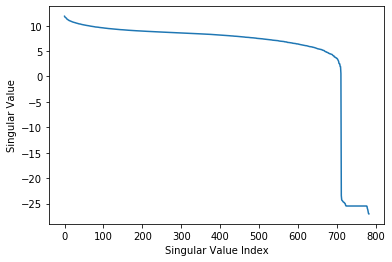

In [47]:
# If we take a quick look at s, there's a clear cut off where the singular values drop under 1
plt.plot(range(784), np.log(s))
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")

In [48]:
# Let's grab those first ones
s_red = [ i for i in s if i > 1]

# x-val
s_red_x = [0,0,0,0,0,0,0]
for j in range(7):
    s_red_x[j] = [ i for i in s_x[j] if i > 1]

# And get our new matrix
A  = U[:,:len(s_red)]@np.diag(s_red)@VT[:len(s_red),:]

#x-val
A_x = [0,0,0,0,0,0,0]
for i in range(7):
    A_x[i] = U_x[i][:,:len(s_red_x[i])]@np.diag(s_red_x[i])@VT[:len(s_red_x[i]),:]

# Add back means and make data rowwise again
A_lr = (A+means).T

A_lr_x = [0,0,0,0,0,0,0]
for i in range(7):
    A_lr_x[i] = (A_x[i]+means_x[i]).T

# 2. Least Squares Algorithm

Need 1/0 label for each of ten classes

In [152]:
y_truths = [[1 if i == j else -1 for i in y_train] for j in range(10)]
y_truths_x = [ [[1 if i == j else -1 for i in y_train_x[k]] for j in range(10)] for k in range(7)]

y_test_truths = [[1 if i == j else -1 for i in y_test] for j in range(10)]
y_test_truths_x = [ [[1 if i == j else -1 for i in y_test_x[k]] for j in range(10)] for k in range(7)]

Find w's

In [150]:
# can play around with lambda later, should be really small since we already controlled for a lot of noise
lam = .00001

# gets w's for numbers 0-9
dubs = [np.linalg.inv(A_lr.T@A_lr + lam*np.identity(784))@A_lr.T@y_truths[i] for i in range(10)]

dubs_x = [ [np.linalg.inv(A_lr_x[k].T@A_lr_x[k] + lam*np.identity(784))@A_lr_x[k].T@y_truths_x[k][i] for i in range(10)] for k in range(7)]

Find Predictions

In [156]:
# Get y_hats of individual error rates for each classification #
y_hats = [x_test_vectorized.T@dubs[i] for i in range(10)]

y_hats_x = [ [x_test_x[k]@dubs[i] for i in range(10)] for k in range(7) ]

Get error_rates of individual error rates for each classification #

In [157]:
error_rates = [np.sum(np.sign(y_hats[i][:]) != y_test_truths[i][:])/10000 for i in range(10)]

error_rates_x = [ [np.sum(np.sign(y_hats_x[k][i][:]) != y_test_truths_x[k][i][:])/10000 for i in range(10)] for k in range(7)]

Error rates among each classification number don't change significantly between original split and validation splits.  Eg. The classification line for number 7 reports "not a seven" in ~3% of cases

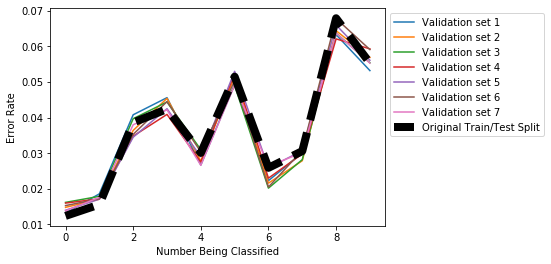

In [178]:
x_vals = range(10)

error_rates_x[0]
for i in range(7):
    plt.plot(x_vals, error_rates_x[i], label='Validation set ' + str(i+1))
    
plt.plot(x_vals,error_rates, 'k', label='Original Train/Test Split', lw=8, ls='--')
    
plt.xlabel('Number Being Classified')
plt.ylabel('Error Rate')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [179]:
y_hats_arr = np.array(y_hats)
y_hats_arr_x = [ np.array(y_hats_x[k]) for k in range(7) ]

# Max value of each test instance
maxes = np.argmax(y_hats_arr, axis=0)
maxes_x = [ np.argmax(y_hats_arr_x[k], axis=0) for k in range(7) ]

error_rate = np.sum(maxes[:] != y_test[:])/10000
error_rate_x = [ np.sum(maxes_x[k][:] != y_test_x[k][:])/10000 for k in range(7) ]

We notice the error rates on the random split test data are slightly than the error rate of the original split

In [182]:
print("Error rate of original split: " + str(error_rate))
print("Average error rate of random split: " + str(np.mean(error_rate_x)))

Error rate of original split: 0.1466
Error rates of random split: 0.15104285714285717


Let's test what a good lambda value would be for the original train/test split.

In [185]:
lams = [.0000001, .000001, .00001, .0001, .001, .01, .1, 1, 10, 10e2, 10e3, 10e4, 10e5, 10e6, 10e7, 10e8, 10e9]

err_rates = []

# Get error_rates for various values of lambda
for lam in lams:
    print(lam)
    # gets w's for numbers 0-9
    dubs = [np.linalg.inv(A_lr.T@A_lr + lam*np.identity(784))@A_lr.T@y_truths[i] for i in range(10)]
    
    # Get y_hats of individual error rates for each classification #
    y_hats = [x_test_vectorized.T@dubs[i] for i in range(10)]
    
    y_hats_arr = np.array(y_hats)

    # Max value of each test instance
    maxes = np.argmax(y_hats_arr, axis=0)
    
    err_rates.append(np.sum(maxes[:] != y_test[:])/10000)

1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1
10
1000.0
10000.0
100000.0
1000000.0
10000000.0
100000000.0
1000000000.0
10000000000.0


Since we already did PCA, lambda doesn't seem to make too much of a difference unless you make it really rally big and then it starts to pull error up.

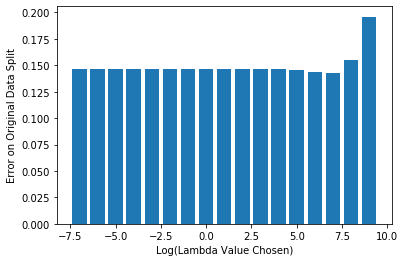

[0.1466, 0.1466, 0.1466, 0.1466, 0.1466, 0.1466, 0.1466, 0.1466, 0.1466, 0.1467, 0.1466, 0.1466, 0.1452, 0.1435, 0.1424, 0.1547, 0.1959]


In [188]:
plt.bar(range(-7,10),err_rates)
plt.xlabel('Log(Lambda Value Chosen)')
plt.ylabel('Error on Original Data Split')
plt.show()
print(err_rates)

# 3. KNN Algorithm

In [14]:
import time
from collections import Counter

def classifyKNN(x_train, x_test, k=1):
    neighbors = []

    start_time = time.time()
    for i_test in range(x_test.shape[0]):#range(100):
        min_vals = [10000000000000000]
        min_indexes = {10000000000000000 : -1}
        
        for j_train in range(x_train.shape[0]):

            
            if np.sum(np.square(x_test[i_test] - x_train[j_train])) < min_vals[-1]:
                
                val = np.sum(np.square(x_test[i_test] - x_train[j_train]))
                
                if val in min_indexes.keys():
                    continue
                
                if len(min_vals) < k:
                    min_vals.append(val)
                    min_indexes[val] = j_train
                else:
                    min_indexes.pop(min_vals[-1])
                    min_vals[-1] = val
                    min_indexes[val] = j_train

                min_vals = sorted(min_vals)

        classes = [y_train[i] for i in min_indexes.values()]
        # https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
        # Break ties more intelligently?
        neighbors.append(Counter(classes).most_common(1)[0][0])
        if i_test % 100 == 0:
            print(time.time()-start_time)
            start_time = time.time()
            
    return neighbors

In [154]:
test_lr = classifyKNN(A_lr, x_test.reshape(10000,784), 9)

1.047199010848999
78.26372575759888
75.4870855808258
79.68086814880371
76.55551409721375
75.4830961227417
74.96348667144775
75.56587624549866
76.10543036460876
77.02597093582153
78.42572045326233
88.24585700035095
89.28986740112305
93.742271900177
76.64299535751343
76.13634753227234
75.55693984031677
75.69848537445068
77.56654810905457
76.14929032325745
75.60676717758179
75.30286574363708
106.98456811904907
76.61854195594788
77.1207594871521
75.06521415710449
76.51531147956848
76.3228497505188
76.93321752548218
74.7011890411377
75.0802104473114
75.65859055519104
74.60132503509521
76.48773670196533
76.00793957710266
74.96747398376465
75.46700406074524
74.1400077342987
75.6945321559906
75.05057382583618
75.2098274230957
75.34094095230103
79.96673846244812
75.18694472312927
74.72515344619751
75.04744982719421
75.90995383262634
74.91564202308655
74.97443008422852
75.27884006500244
79.13831901550293
74.81987142562866
96.0046739578247
95.76508474349976
100.29990983009338
93.6715292930603
92.

In [155]:
errors = 0
for i in range(10000):
    if y_test[i] != test_lr[i]:
        errors += 1

print(errors/10000)

0.0338


In [16]:
err_list = []
for k in [1,5,9,13,27]:
    print("-----------------------------------------------------")
    print("K")
    print(k)
    print("----------------------------------------------------")
    test_lr = classifyKNN(A_lr, x_test.reshape(10000,784), k)
    errors = 0
    for i in range(10000):
        if y_test[i] != test_lr[i]:
            errors += 1
    err_list.append(errors/10000)

-----------------------------------------------------
K
1
----------------------------------------------------
0.8387939929962158
85.74226713180542
87.47162628173828
80.86468076705933
81.54292893409729
84.53880143165588
78.4593939781189
82.45039820671082
87.16243243217468
78.98439621925354
80.30018448829651
78.93489933013916
79.66723775863647
76.60471749305725
76.96612572669983
77.84376001358032
82.98471665382385
85.98672747612
83.07408666610718
77.09446835517883
78.4713282585144
90.14207172393799
79.71199131011963
77.80095911026001
81.12457990646362
86.58564949035645
94.12123918533325
79.22140979766846
86.14365601539612
77.79839205741882
78.22474265098572
87.37238812446594
77.33791303634644
92.31278347969055
80.10667085647583
79.8223066329956
81.32427072525024
83.2483742237091
83.56556487083435
81.54603266716003
83.04789161682129
83.65834331512451
81.35140323638916
82.80506443977356
82.4474446773529
82.12405610084534
80.90554785728455
82.16619801521301
101.76738715171814
82.6175096035

78.25665831565857
77.36703491210938
77.48771333694458
80.88130593299866
77.39795351028442
77.89010739326477
77.0488862991333
77.85950803756714
77.28026914596558
77.36504101753235
77.65024900436401
77.66423988342285
77.68618488311768
77.6173677444458
77.65726733207703
77.7134153842926
77.4049346446991
77.32614636421204
78.0447084903717
77.59442973136902
77.97540879249573
78.17686820030212
78.56658673286438
77.68614220619202
77.85102725028992
77.07657194137573
77.33013653755188
77.79588794708252
78.06820869445801
77.89661908149719
77.25897717475891
77.27487969398499
78.1389708518982
79.61901378631592
77.46445560455322
77.93776607513428
78.21873545646667
77.69273257255554
78.11992931365967
77.40175080299377
77.2792706489563
77.68283319473267
77.68418669700623
77.22042727470398
77.98438501358032
78.46514987945557
78.06826400756836
77.70912218093872
77.61038565635681
81.16414737701416
78.09110069274902
78.12301254272461
77.37701153755188
77.79838752746582
77.57848930358887
77.72612118721008

Text(0, 0.5, 'error rate')

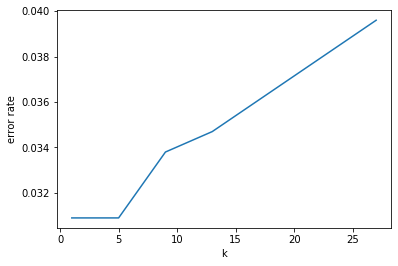

In [17]:
plt.plot([1,5,9,13,27], err_list)
plt.xlabel("k")
plt.ylabel("error rate")

In [18]:
print(err_list)

[0.0309, 0.0309, 0.0338, 0.0347, 0.0396]


# 4. Neural Network

# 4a. Building a Network, Determining Amount of Hidden Layer Nodes

Start by creating a neural network with one hidden layer.  We'll try to determine how many nodes in this first layer is best-suited for the model on the original split of data.

NOTE: All of the explanations for how I decided the basic parameters for this model are explained in the cell below. These explanations will not be repeated in future cells.  The purpose of this first cell is to get a general idea of the optimal dimensionality of the hidden relu layer.  We will use 5 epochs for speed to get a general idea, until we pare down to a smaller range.  We'll evaluate which is the best based on the same test set.

In [191]:
# dimensions and error for those dimensions
dim = range(10,1010,100)
err = []

for i in dim:
    print(i)
    # First Layer: relu function- This allows for quick computation as we sort through the dimensionality of the data
    # Output Layer: Softmax function in the output layer since we have > 2 output classes
    # Softmax allows for a good probabilistic interpretation (between 0 and 1), to compare the output classes with one another.  
    # We know there are ten classes, so we'll set dimensionality (units) of output layer to ten
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(i,activation='relu'),
                                        tf.keras.layers.Dense(10, activation='softmax')])

    # We don't want to have problems with outliers,so we won't use mean squared error.  
    # Our data is categorical, so categorical cross entrpy makes sense.
    # Since we have y_train as ints, and we didn't one-hot encode, we have to use sparse_categorical_crossentropy
    # It's faster anyway, see https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other
    # Use adam optimizer (seems to be standard for stochastic gradient descent from looking online)
    # Will change optimizer if problems are found.  Same with default learning rate of .001 that comes with optimizer
    # Accuracy defaults to categorical accuracy: see https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    model.fit(A_lr, y_train, epochs=5)

    pred = np.argmax(model.predict(x_test_vectorized.T), axis=1)
    
    err.append(sum(y_test != pred)/len(y_test))

10
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 53us/sample - loss: 2.5806 - acc: 0.2021
Epoch 2/5
60000/60000 [==============================] - 3s 51us/sample - loss: 1.8119 - acc: 0.3108
Epoch 3/5
60000/60000 [==============================] - 3s 47us/sample - loss: 1.4724 - acc: 0.4534
Epoch 4/5
60000/60000 [==============================] - 3s 48us/sample - loss: 1.2424 - acc: 0.5303
Epoch 5/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.9845 - acc: 0.6342
110
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 69us/sample - loss: 2.2360 - acc: 0.8387
Epoch 2/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.4068 - acc: 0.9015
Epoch 3/5
60000/60000 [==============================] - 3s 57us/sample - loss: 0.2834 - acc: 0.9279
Epoch 4/5
60000/60000 [==============================] - 4s 58us/sample - loss: 0.2404 - acc: 0.9387
Epoch 5/5
60000/60000 [===============

Note: dim[0] was very large and skewed the shape of the graph so was excluded.

Text(0.5, 0, 'Dimensionality of Relu layer')

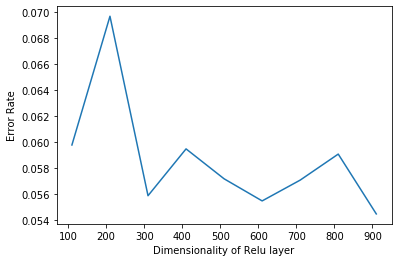

In [193]:
plt.plot(dim[1:10], err[1:10])
plt.ylabel("Error Rate")
plt.xlabel("Dimensionality of Relu layer")

Clearly, we should look closer in the 600-800 range.  So, I'm gonna lower the jumps to 20 to see if we can find a good dimensionality.  Maybe 712 makes sense since that's how many singular values we had, I'll make sure to pass through that number.

In [8]:
dim2 = range(652,753,20)
err2 = []

for i in dim2:
    print(i)
    model = tf.keras.models.Sequential([tf.keras.layers.Dense(i,activation='relu'),
                                        tf.keras.layers.Dense(10, activation='softmax')])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    model.fit(A_lr, y_train, epochs=5)

    pred2 = np.argmax(model.predict(x_test_vectorized.T), axis=1)
    
    err2.append(sum(y_test != pred2)/len(y_test))

652
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 210us/sample - loss: 2.4897 - acc: 0.9088
Epoch 2/5
60000/60000 [==============================] - 11s 180us/sample - loss: 0.3494 - acc: 0.9382
Epoch 3/5
60000/60000 [==============================] - 11s 183us/sample - loss: 0.3139 - acc: 0.9408
Epoch 4/5
60000/60000 [==============================] - 11s 188us/sample - loss: 0.2777 - acc: 0.9477
Epoch 5/5
60000/60000 [==============================] - 11s 177us/sample - loss: 0.2607 - acc: 0.9505
672
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 11s 179us/sample - loss: 2.4846 - acc: 0.9089
Epoch 2/5
60000/60000 [==============================] - 10s 163us/sample - loss: 0.3409 - acc: 0.9381
Epoch 3/5
60000/60000 [==============================] - 10s 167us/sample - loss: 0.3227 - acc: 0.9391
Epoch 4/5
60000/60000 [==============================] - 10s 161us/sample - loss: 0.2888 - acc: 0.9441
Epoch 5/5
60000/600

Text(0.5, 0, 'Dimensionality of Relu layer')

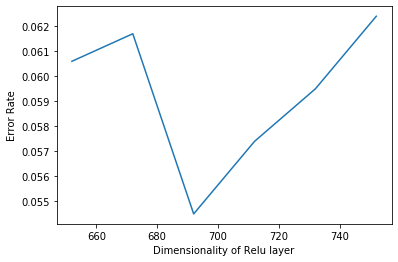

In [9]:
plt.plot(dim2, err2)
plt.ylabel("Error Rate")
plt.xlabel("Dimensionality of Relu layer")

Looks like 692 is the best so let's try that with more epochs.

In [10]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(692,activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.fit(A_lr, y_train, epochs=20)

pred3 = np.argmax(model.predict(x_test_vectorized.T), axis=1)

sum(y_test != pred3)/len(y_test)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 168us/sample - loss: 2.6388 - acc: 0.9101
Epoch 2/20
60000/60000 [==============================] - 10s 165us/sample - loss: 0.3494 - acc: 0.9394
Epoch 3/20
60000/60000 [==============================] - 10s 161us/sample - loss: 0.3402 - acc: 0.9405
Epoch 4/20
60000/60000 [==============================] - 10s 164us/sample - loss: 0.2732 - acc: 0.9468
Epoch 5/20
60000/60000 [==============================] - 9s 156us/sample - loss: 0.2538 - acc: 0.9491
Epoch 6/20
60000/60000 [==============================] - 10s 168us/sample - loss: 0.2396 - acc: 0.9513
Epoch 7/20
60000/60000 [==============================] - 10s 166us/sample - loss: 0.2216 - acc: 0.9558
Epoch 8/20
60000/60000 [==============================] - 9s 157us/sample - loss: 0.2198 - acc: 0.9577
Epoch 9/20
60000/60000 [==============================] - 10s 165us/sample - loss: 0.2050 - acc: 0.9603
Epoch 10/20
60000/60000 [==================

0.0452

I wonder if 712 is the best actually, let's just try that.

In [11]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(712,activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.fit(A_lr, y_train, epochs=20)

pred4 = np.argmax(model.predict(x_test_vectorized.T), axis=1)

err_nn = sum(y_test != pred4)/len(y_test)

err_nn

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 172us/sample - loss: 2.7497 - acc: 0.9123
Epoch 2/20
60000/60000 [==============================] - 10s 167us/sample - loss: 0.3709 - acc: 0.9380
Epoch 3/20
60000/60000 [==============================] - 10s 166us/sample - loss: 0.3434 - acc: 0.9406
Epoch 4/20
60000/60000 [==============================] - 10s 166us/sample - loss: 0.2788 - acc: 0.9466
Epoch 5/20
60000/60000 [==============================] - 10s 161us/sample - loss: 0.2628 - acc: 0.9506
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 0.2413 - acc: 0.9538
Epoch 7/20
60000/60000 [==============================] - 10s 166us/sample - loss: 0.2239 - acc: 0.9562
Epoch 8/20
60000/60000 [==============================] - 10s 165us/sample - loss: 0.2252 - acc: 0.9573
Epoch 9/20
60000/60000 [==============================] - 10s 167us/sample - loss: 0.2048 - acc: 0.9615
Epoch 10/20
60000/60000 [================

0.0464

Hmmmm, this is very close. Let's use whatever amount of values we kept in our SVD for our relu dimensionality.

# 4b. Cross-Validation Neural Networks

Let's try running the same thing with our cross-validation sets (except with 10 epochs to go faster).  We'll use the number of singular values we kept as the number of number of hidden nodes and compare to the regular split of training/test.

In [49]:
err_nn_x = [0,0,0,0,0,0,0]

for k in range(7):
    print(len(s_red_x[k]))

    model2 = tf.keras.models.Sequential([tf.keras.layers.Dense(10,activation='relu'),
                                        tf.keras.layers.Dense(10, activation='softmax')])

    model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

    model2.fit(A_lr_x[k], y_train_x[k], epochs=10)

    tmp = np.argmax(model2.predict(x_test_x[k]), axis=1)

    err_nn_x[k] = sum(y_test_x[k] != tmp)/len(y_test_x[k])

698
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/sample - loss: 2.9444 - acc: 0.1138
Epoch 2/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.3009 - acc: 0.1138
Epoch 3/10
60000/60000 [==============================] - 3s 52us/sample - loss: 2.3008 - acc: 0.1138
Epoch 4/10
60000/60000 [==============================] - 3s 48us/sample - loss: 2.3010 - acc: 0.1138
Epoch 5/10
60000/60000 [==============================] - 3s 45us/sample - loss: 2.3009 - acc: 0.1138
Epoch 6/10
60000/60000 [==============================] - 3s 47us/sample - loss: 2.3008 - acc: 0.1138
Epoch 7/10
60000/60000 [==============================] - 3s 47us/sample - loss: 2.3009 - acc: 0.1138
Epoch 8/10
60000/60000 [==============================] - 3s 53us/sample - loss: 2.3009 - acc: 0.1138
Epoch 9/10
60000/60000 [==============================] - 3s 49us/sample - loss: 2.3008 - acc: 0.1138
Epoch 10/10
60000/60000 [==============================

KeyboardInterrupt: 

Have to re-run the regular cross-validation set with 10 epochs.

In [50]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(712,activation='relu'),
                                    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(A_lr, y_train, epochs=10)
pred4 = np.argmax(model.predict(x_test_vectorized.T), axis=1)
err_nn = sum(y_test != pred4)/len(y_test)

err_nn

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 164us/sample - loss: 2.6101 - acc: 0.9095
Epoch 2/10
60000/60000 [==============================] - 10s 163us/sample - loss: 0.3642 - acc: 0.9359
Epoch 3/10
60000/60000 [==============================] - 10s 172us/sample - loss: 0.3621 - acc: 0.9385
Epoch 4/10
60000/60000 [==============================] - 10s 160us/sample - loss: 0.2749 - acc: 0.9476
Epoch 5/10
60000/60000 [==============================] - 10s 171us/sample - loss: 0.2581 - acc: 0.9489
Epoch 6/10
60000/60000 [==============================] - 10s 171us/sample - loss: 0.2447 - acc: 0.9533
Epoch 7/10
60000/60000 [==============================] - 11s 179us/sample - loss: 0.2257 - acc: 0.9570
Epoch 8/10
60000/60000 [==============================] - 13s 219us/sample - loss: 0.2178 - acc: 0.9595
Epoch 9/10
60000/60000 [==============================] - 11s 187us/sample - loss: 0.2109 - acc: 0.9599
Epoch 10/10
60000/60000 [================

0.0538

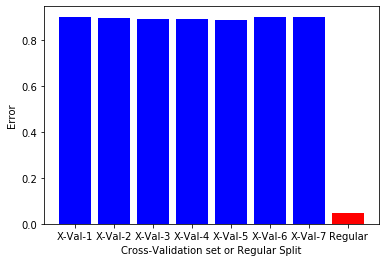

NameError: name 'err_rates' is not defined

In [16]:
err_nn_x.append(err_nn)
plt.bar(['X-Val-1','X-Val-2','X-Val-3','X-Val-4','X-Val-5','X-Val-6','X-Val-7','Regular'], err_nn_x, color = ('b','b','b','b','b','b','b','r'))
plt.xlabel('Cross-Validation set or Regular Split')
plt.ylabel('Error')
plt.show()

In [17]:
for k in range(7):
    print(len(s_red_x[k]))

701
699
704
693
697
698
694


In [21]:
x_test_x[1].shape

(10000, 784)

In [22]:
x_test_vectorized.T.shape

(10000, 784)

In [23]:
A_lr_x[0].shape

(60000, 784)

In [24]:
A_lr.shape

(60000, 784)

In [25]:
y_test_x[0].shape

(10000,)

In [26]:
y_test.shape

(10000,)

In [28]:
y_train_x[0].shape

(60000,)

In [29]:
y_train.shape

(60000,)

In [43]:
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [42]:
y_train_x[0][:10]

array([5, 0, 5, 1, 4, 1, 1, 3, 1, 0], dtype=uint8)

In [55]:
tst = A_lr_x[0].reshape(60000,28,28)
tst2 = [np.round(1.0*i/256) for i in tst] 

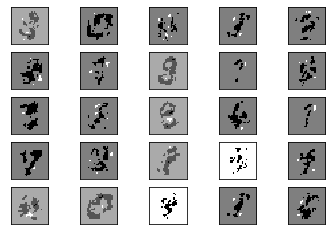

In [57]:
show_images(tst2, 5, 5)

In [58]:
tst = A_lr.reshape(60000,28,28)
tst2 = [np.round(1.0*i/256) for i in tst] 

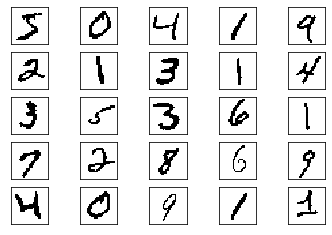

In [59]:
show_images(tst2, 5, 5)